In [ ]:
!pip install gymnasium[atari] stable-baselines3[extra] torch tensorboard ale-py
!pip install jupyter matplotlib


In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
# Create Breakout environment with frame skip & preprocessing
from gymnasium.wrappers import FrameStackObservation,AtariPreprocessing
from stable_baselines3.common.callbacks import BaseCallback

class TrackProgressCallback(BaseCallback):
    def __init__(self, save_freq=100_000, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []
        self.avg_rewards = []
        self.save_freq = save_freq

    def _on_step(self):
        # Track episode reward
        if len(self.locals["infos"]) > 0 and "episode" in self.locals["infos"][0]:
            r = self.locals["infos"][0]["episode"]["r"]
            self.episode_rewards.append(r)
            # Running mean for last 100 episodes
            avg = np.mean(self.episode_rewards[-100:]) if len(self.episode_rewards) > 0 else r
            self.avg_rewards.append(avg)
        # Save weights at intervals
        if self.num_timesteps % self.save_freq == 0:
            self.model.save(f"dqn_breakout_step_{self.num_timesteps}")
        return True

    def _on_training_end(self):
        np.save("episode_rewards.npy", np.array(self.episode_rewards))
        np.save("average_rewards.npy", np.array(self.avg_rewards))

env = gym.make("ALE/Breakout-v5", render_mode="rgb_array",frameskip=1)
env = AtariPreprocessing(env, terminal_on_life_loss=True)
env = FrameStackObservation(env, stack_size=4)


In [ ]:
import gymnasium
import ale_py
import stable_baselines3
import matplotlib

print("Gymnasium version:", gymnasium.__version__)
print("ALE-Py version:", ale_py.__version__)
print("Stable Baselines3 version:", stable_baselines3.__version__)
print("Matplotlib version:", matplotlib.__version__)

Gymnasium version: 1.2.1
ALE-Py version: 0.11.2
Stable Baselines3 version: 2.7.0
Matplotlib version: 3.10.0


In [ ]:
from stable_baselines3 import PPO
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func



# Initialize PPO with CNN policy for pixel input
model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    learning_rate=linear_schedule(2.5e-4),
    clip_range=linear_schedule(0.1),
    n_steps=128,               # PPO rollouts
    batch_size=256,
    n_epochs=4,
    gamma=0.99,            # Clipping hyperparameter, usually 0.1-0.3
    ent_coef=0.01,             # Entropy bonus for exploration
    tensorboard_log="./tensorboard_log_ppo/",
    device="cuda"              # GPU acceleration if available
)

progress = TrackProgressCallback(save_freq=100_000)
# Train for 1 million steps (adjust if needed)
model.learn(total_timesteps=3_000_000,callback=progress)

# Save the trained PPO model
model.save("ppo_breakout")
print("Finished training and tracking progress.")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  warnings.warn(


Logging to ./tensorboard_log_ppo/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 175      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 46.6          |
|    ep_rew_mean          | 0.4           |
| time/                   |               |
|    fps                  | 92            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00074310694 |
|    clip_fraction        | 0             |
|    clip_range           | 0.0987        |
|    entropy_loss         | -1.39         |
|    

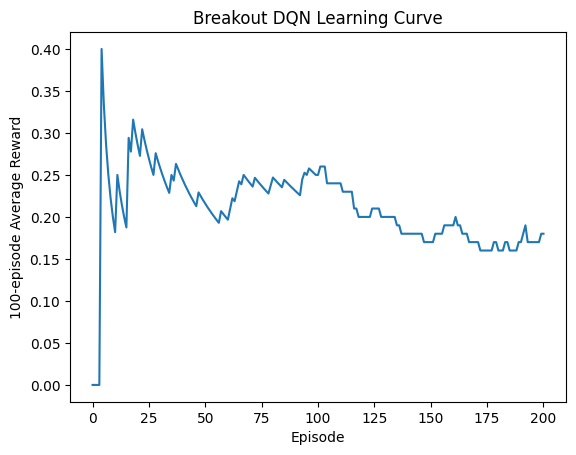

Eval total reward: 0.0


In [ ]:
import matplotlib.pyplot as plt
ep_rewards = np.load("episode_rewards.npy")
avg_rewards = np.load("average_rewards.npy")

plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("100-episode Average Reward")
plt.title("Breakout DQN Learning Curve")
plt.show()

# Evaluation (can also record video as in your code block)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array",frameskip=1)
env = AtariPreprocessing(env, terminal_on_life_loss=True)
env = FrameStackObservation(env, stack_size=4)

obs, _ = env.reset()
done, truncated = False, False
total_reward = 0
while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
print("Eval total reward:", total_reward)

In [ ]:
obs, _ = env.reset()
done, truncated = False, False
total_reward = 0

while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print("Total reward from PPO agent:", total_reward)


Total reward from PPO agent: 0.0


In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def make_env():
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array",frameskip=1)
    env = AtariPreprocessing(env, terminal_on_life_loss=True)
    env = FrameStackObservation(env, stack_size=4)
    return env

env = DummyVecEnv([make_env])
env = VecVideoRecorder(
    env,
    "./videos/",
    record_video_trigger=lambda step: True,  # Record every eval episode
    video_length=1000,
    name_prefix="dqn-breakout"
)

obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = env.step(action)
env.close()


Saving video to /content/videos/dqn-breakout-step-0-to-step-1000.mp4
Moviepy - Building video /content/videos/dqn-breakout-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/dqn-breakout-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-breakout-step-0-to-step-1000.mp4


In [ ]:
from IPython.display import Video
Video('/content/videos/dqn-breakout-step-0-to-step-1000.mp4', embed=True)
